# EEG Signal Classification using Deep Learning

## Load Librairies

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import os
import scipy.io as sc
import tensorflow as tf
from keras import layers, models
from keras import backend as K
import numpy as np

from src.data.paradigm import PARADIGM

In [75]:
RANDOM_STATE = 42  
np.random.seed(RANDOM_STATE)

In [76]:
os.chdir("../")
DATA_DIR = "C:/Users/Heni/Documents/BCI_Comp_III_Wads_2004/" #root path of data

## Read in the data from .mat

In [78]:
print(DATA_DIR)

C:/Users/Heni/Documents/BCI_Comp_III_Wads_2004/


In [79]:
train = sc.loadmat(DATA_DIR + "Subject_A_Train.mat") # Training Data .mat
test = sc.loadmat(DATA_DIR + "Subject_A_Test.mat") # Test Data .mat

In [80]:
train

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Mon Nov 29 08:14:54 2004',
 '__version__': '1.0',
 '__globals__': [],
 'Signal': array([[[ 8.0849998e-02, -1.7930571e+01, -9.2669497e+00, ...,
          -1.9443050e+01, -1.0342620e+01, -1.4575340e+01],
         [-2.2476299e+00, -1.7676010e+01, -6.4597502e+00, ...,
          -1.7911850e+01, -8.0227804e+00, -1.3052780e+01],
         [ 7.5837302e+00, -1.4875850e+01, -3.3973501e+00, ...,
          -1.4083850e+01, -4.1563802e+00, -9.7538996e+00],
         ...,
         [-2.6567310e+01, -1.4366730e+01, -2.4068550e+01, ...,
           5.0561500e+00, -1.3210200e+00,  3.9491401e+00],
         [-2.1651630e+01, -1.2330250e+01, -2.0750950e+01, ...,
           9.7294998e-01, -2.0943000e+00,  1.1577801e+00],
         [-2.2169069e+01, -1.5130410e+01, -2.4068550e+01, ...,
          -1.3238500e+00, -4.6718998e+00, -1.6335800e+00]],
 
        [[ 1.5086610e+01,  1.1598390e+01,  1.2680250e+01, ...,
          -3.6206501e+00,  7.1850600e+00,

In [81]:
test

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Mon Nov 29 08:13:56 2004',
 '__version__': '1.0',
 '__globals__': [],
 'Signal': array([[[-1.621851e+01, -1.411217e+01, -9.777350e+00, ...,
          -1.918785e+01, -1.987974e+01,  1.411540e+00],
         [-1.285515e+01, -1.385761e+01, -1.003255e+01, ...,
          -2.454705e+01, -2.323062e+01, -4.171180e+00],
         [-1.259643e+01, -1.385761e+01, -1.003255e+01, ...,
          -2.811985e+01, -2.606598e+01, -1.000766e+01],
         ...,
         [-1.621851e+01, -1.614865e+01, -1.232935e+01, ...,
          -3.030500e-01,  4.607460e+00,  9.040200e-01],
         [-1.285515e+01, -1.334849e+01, -1.079815e+01, ...,
          -2.344650e+00,  2.545380e+00,  1.427400e-01],
         [-1.440747e+01, -1.742145e+01, -1.513655e+01, ...,
          -5.407050e+00, -1.321020e+00, -2.902380e+00]],
 
        [[ 2.409330e+00,  1.210751e+01,  1.114905e+01, ...,
          -4.641450e+00, -2.609820e+00, -8.992620e+00],
         [ 2.926770e+00,

In [82]:
train.keys() # Dict Train keys 

dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'TargetChar', 'Flashing', 'StimulusCode', 'StimulusType'])

In [83]:
test.keys() # Dict Test keys

dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'Flashing', 'StimulusCode'])

## Preprocessing

In [84]:
NUM_CHARS, NUM_SAMPLES, NUM_ELECTRODES = train['Signal'].shape
print(NUM_CHARS, NUM_SAMPLES, NUM_ELECTRODES)

85 7794 64


In [85]:
NUM_ROWCOLS = 12

# Each character is runned for 15 times
NUM_REPEAT = 15

# Sampling frequency
FS = 240

SECONDS_TO_SLICE = 0.65    

In [86]:
from src.data.preprocessing import transform
train = transform(train, FS, NUM_ROWCOLS, NUM_REPEAT, SECONDS_TO_SLICE)
test = transform(test, FS, NUM_ROWCOLS, NUM_REPEAT, SECONDS_TO_SLICE)

In [87]:
train.keys()

dict_keys(['signal', 'code', 'label', 'targetchar'])

In [88]:
test.keys()

dict_keys(['signal', 'code'])

In [89]:
train['signal'].shape

(85, 15, 12, 64, 156)

In [90]:
print(train['label'].shape)
print(train['targetchar'].shape)
print(train['code'].shape)

(85, 15, 12)
(85,)
(85, 15, 12)


In [91]:
from src.data.preprocessing import subsample, butter_bandpass_filter, standardize_along

for d in [train, test]:

    subsample_interval = 2

    d['signal'] = subsample(d['signal'], subsample_interval)

    lowcut = 0.1
    highcut = 20
    order = 5
    FS_subsampled = int(FS/subsample_interval)
    d['signal'] = butter_bandpass_filter(d['signal'], lowcut, highcut,
                                             FS_subsampled, order, -1)

    d['signal'] = standardize_along(d['signal'], -1).reshape([-1, NUM_ELECTRODES, 
                                                            d['signal'].shape[-1], 1])

train['signal'].shape
test['signal'].shape
train['label'].shape
train['label'][0][0]
train['label'] = to_categorical(train['label'].reshape([-1, ]))

## Training

In [92]:


def CNN_1_P300_PAMI_BCIIII(Ns=10, seconds_to_slice=0.65):


    # Let's define the custom activation function used in this layer first
    def sigmoid_pami_p300(x):
        return 1.7159 * K.tanh(2 * x / 3)

    tf.keras.utils.get_custom_objects().update({'custom_activation': layers.Activation(sigmoid_pami_p300)})

    # Then we build the model
    num_electrodes = 64
    Fs = 120  
    points_to_slice = int(Fs * seconds_to_slice)
    input_layer = layers.Input([num_electrodes, points_to_slice, 1])
    conv_1 = layers.convolutional.Conv2D(filters=Ns, kernel_size=[num_electrodes, 1], strides=[1, 1],
                                         activation='linear')(input_layer)

    conv_1_acti = layers.Activation(sigmoid_pami_p300)(conv_1)
    conv_2 = layers.convolutional.Conv2D(filters=5 * Ns, kernel_size=[1, 13], strides=[1, 13],
                                         activation='linear')(conv_1_acti)
    conv_2_acti = layers.Activation(sigmoid_pami_p300)(conv_2)
    flatten = layers.Flatten()(conv_2_acti)
    fc = layers.Dense(100, activation='sigmoid')(flatten)
    output_layer = layers.Dense(2, activation='sigmoid')(fc)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

def CNN_P300_PAMI(input_shape):

    def sigmoid_pami_p300(x):
        return 1.7159 * K.tanh(2 * x / 3)
    tf.keras.utils.get_custom_objects().update({'custom_activation': layers.Activation(sigmoid_pami_p300)})

    # Then we build the model
    num_electrodes, points_to_slice = input_shape[0:2]
    num_first_filter = 10
    num_second_filter = 5 * num_first_filter

    input_layer = layers.Input(input_shape)
    # Combining all the electrodes.
    conv_1 = layers.convolutional.Conv2D(filters=num_first_filter, kernel_size=[num_electrodes, 1], 
                                        strides=[1, 1], activation='linear')(input_layer)
    conv_1_acti = layers.Activation(sigmoid_pami_p300)(conv_1)

    conv_2 = layers.convolutional.Conv2D(filters=num_second_filter, kernel_size=[1, 13], 
                                        strides=[1, 13], activation='linear')(conv_1_acti)
    conv_2_acti = layers.Activation(sigmoid_pami_p300)(conv_2)
    flatten = layers.Flatten()(conv_2_acti)
    fc = layers.Dense(100, activation='sigmoid')(flatten)
    output_layer = layers.Dense(2, activation='sigmoid')(fc)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

def testing_pipeline(data, trained_model, num_aggregate, answer_string):

    if num_aggregate != "all":        # int
        aggregated = _signalcode_to_aggregate(data, trained_model, num_aggregate)
        letters = _aggregated_to_letters(aggregated)
        return [accuracy(letters, answer_string)]
    else:                           # "all"
        accuracies = []
        for i in range(15):
            accuracies += testing_pipeline(data, trained_model, i+1, answer_string)
        return accuracies

def _letter_lookup(data):


    def __look_up(arr, paradigm=PARADIGM):
        """ arr[0]  0~5->1~6  arr[1] 0~5->7~12 """
        return paradigm[arr[1], arr[0]]

    return np.apply_along_axis(__look_up, axis=1, arr=data)

def _prob_to_rowcols(prob):

    ascend_indices = np.argsort(prob, axis=-1)  # (num_letters,12)     # ascending
    selected = np.full((prob.shape[0], 2), np.inf)
    for i in range(selected.shape[0]):
        for j in reversed(range(ascend_indices.shape[1])):
            if ascend_indices[i][j] >= 6 and selected[i][1] == np.inf:
                selected[i][1] = ascend_indices[i][j] - 6
            elif ascend_indices[i][j] <= 5 and selected[i][0] == np.inf:
                selected[i][0] = ascend_indices[i][j]
    return selected.astype(int)

def _code_reorder(probs, code):

    sort = np.zeros(probs.shape)
    for i in range(probs.shape[0]):
        for j in range(probs.shape[1]):
            sort[i, j, :] = probs[i, j, np.argsort(code[i,j])]
    return sort

def _aggregate_prob_across_trials(sort, num_aggregate):
    to_aggregate = np.delete(sort, obj=np.s_[num_aggregate:], axis=1)  # (num_chars, num_repeats, 12)
    # Then sum up
    aggregated = to_aggregate.sum(axis=1)   # (num_chars,12)  # aggregated probabilities
    return aggregated

def _signalcode_to_aggregate(data, model, num_aggregate):
    predictions = model.predict(data['signal'])  # [num_samples,2]
    dropped = np.delete(predictions, 0, -1).squeeze()  # [num_samples,]
    reshaped = dropped.reshape([-1, 15, 12])  # may be different
    sort = _code_reorder(reshaped, data['code'])  # [num_chars,15,12]
    aggregated = _aggregate_prob_across_trials(sort, num_aggregate)  # aggregate the probabilities
    return aggregated

def _aggregated_to_letters(aggregated):
  
    selected = _prob_to_rowcols(aggregated)
    letters = _letter_lookup(selected)
    return letters

def accuracy(letters, target_string):
    count = 0
    for i in range(len(target_string)):
        if letters[i] == target_string[i]:
            count += 1
    return count / len(target_string)
    
    

In [93]:
X_train, X_val, y_train, y_val = train_test_split(train['signal'], train['label'], test_size=0.05,
                                                  random_state=RANDOM_STATE, stratify=train['label'])
model = CNN_P300_PAMI(train['signal'].shape[1:])
model.compile(optimizer = 'sgd',loss = 'binary_crossentropy',metrics = ['acc', 'mse'])
earlystopping = EarlyStopping(monitor = "val_mean_squared_error",patience = 3)
model.fit(x = X_train, y = y_train, batch_size=32, epochs = 1000, callbacks = [earlystopping], 
              validation_data = [X_val,y_val])

Epoch 1/1000
455/455 [==============================] - 2s 4ms/step - loss: 0.4629 - acc: 0.8281 - mse: 0.1441 - val_loss: 0.4503 - val_acc: 0.8327 - val_mse: 0.1390
Epoch 2/1000
455/455 [==============================] - 1s 3ms/step - loss: 0.4475 - acc: 0.8334 - mse: 0.1380 - val_loss: 0.4472 - val_acc: 0.8327 - val_mse: 0.1381
Epoch 3/1000
455/455 [==============================] - 1s 3ms/step - loss: 0.4437 - acc: 0.8334 - mse: 0.1370 - val_loss: 0.4428 - val_acc: 0.8327 - val_mse: 0.1368
Epoch 4/1000
455/455 [==============================] - 1s 3ms/step - loss: 0.4388 - acc: 0.8334 - mse: 0.1356 - val_loss: 0.4378 - val_acc: 0.8327 - val_mse: 0.1354
Epoch 5/1000
455/455 [==============================] - 1s 3ms/step - loss: 0.4329 - acc: 0.8334 - mse: 0.1338 - val_loss: 0.4321 - val_acc: 0.8327 - val_mse: 0.1338
Epoch 6/1000
455/455 [==============================] - 1s 3ms/step - loss: 0.4262 - acc: 0.8334 - mse: 0.1318 - val_loss: 0.4255 - val_acc: 0.8327 - val_mse: 0.1320
Epoc

## Testing

In [94]:
def testing_pipeline(data, trained_model, num_aggregate, answer_string):
    if num_aggregate != "all":        # int
        aggregated = _signalcode_to_aggregate(data, trained_model, num_aggregate)
        letters = _aggregated_to_letters(aggregated)
        return [accuracy(letters, answer_string)]
    else:                           # "all"
        accuracies = []
        for i in range(15):
            accuracies += testing_pipeline(data, trained_model, i+1, answer_string)
        return accuracies

100
563/563 [==============================] - 1s 1ms/step
[[2.54462141e-13 1.00826301e-05 1.80286701e-08 ... 1.83270331e-05
  6.62581215e-06 1.36867122e-04]
 [2.37740438e-10 6.14471446e-14 8.18338431e-03 ... 2.94416386e-05
  5.10876362e-07 2.08890256e-08]
 [1.70697986e-05 1.90291461e-02 1.60952588e-03 ... 1.39049152e-05
  8.73314366e-06 9.03431719e-05]
 ...
 [1.68762633e-15 6.28990859e-09 5.86863780e-06 ... 8.21201047e-06
  1.71999588e-08 1.68180178e-10]
 [1.12747693e-04 9.99676764e-01 9.56518864e-09 ... 4.78992524e-06
  2.52048071e-08 5.33513776e-06]
 [1.00217247e-03 1.11772388e-04 1.13168405e-03 ... 9.95870352e-01
  3.18805769e-06 1.83419131e-11]]
100
563/563 [==============================] - 1s 1ms/step
[[9.78581303e-11 1.02819382e-05 3.18933356e-01 ... 1.83364815e-05
  9.99985168e-01 1.36867168e-04]
 [1.04945448e-06 5.37907912e-09 8.18392549e-03 ... 2.94416647e-05
  6.83003914e-05 5.14297804e-01]
 [1.71322944e-05 6.58765143e-01 1.60952588e-03 ... 1.37284519e-01
  4.98026789e-01 9

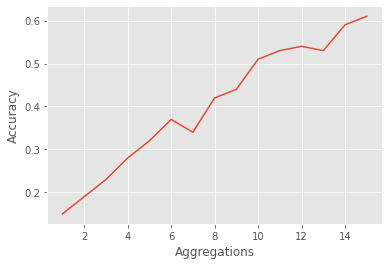

In [95]:
test.keys()
test['signal'].shape
test['code'].shape
with open(DATA_DIR + "true_labels_a.txt") as f:
    answer = f.readline()
model_scores = testing_pipeline(test, model, "all", answer)
print(model_scores)
plt.style.use("ggplot")
plt.plot(np.arange(15)+1, model_scores)
plt.xlabel("Aggregations")
plt.ylabel("Accuracy")
plt.grid(True)